In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train and deploy PyTorch models with prebuilt containers on Vertex AI


<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/prediction/pytorch_train_deploy_models_with_prebuilt_containers.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/prediction/pytorch_train_deploy_models_with_prebuilt_containers.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/prediction/pytorch_train_deploy_models_with_prebuilt_containers.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Overview

Vertex AI provides Docker container images that you run as prebuilt containers for custom training and prediction. These containers, which are organized by machine learning (ML) framework and framework version, include common dependencies that you might want to use in training code and serving predictions. Using pre-built containers is generally simpler than creating your own custom containers.

This tutorial demonstrates how to train and deploy a PyTorch image model with prebuilt containers on Vertex AI.

- Learn more about [Prebuilt containers for custom training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers)
- Learn more about [Prebuilt containers for prediction and explanation](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)


### Objective

In this tutorial, you learn how to build, train and deploy a PyTorch image classification model using prebuilt containers for custom training and prediction.

This tutorial uses the following Google Cloud ML services and resources:

- `Vertex AI Training` service
- `Vertex AI Prediction` service
- `Vertex AI Model Registry`
- `Vertex AI Model` resources
- `Vertex AI Endpoint` resources


The steps performed include:

- Package training application into a Python source distribution
- Configure and run training job in a prebuilt container
- Package model artifacts in a model archive file
- Upload model for deployment
- Deploy model using a prebuilt container for prediction
- Make online predictions


### Dataset/Model

In this tutorial, you use the [MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) handwritten digit recognition dataset from PyTorch torchvision dataset. You train a simple Convolutional Neural Network on the MNIST dataset to identify handwritten digits.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing),
and [Cloud Storage pricing](https://cloud.google.com/storage/pricing),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

Install the following packages required to execute this notebook.


In [1]:
! pip3 install --upgrade --quiet google-cloud-aiplatform \
                                 torch \
                                 torchvision \
                                 torch-model-archiver

### Colab only: Uncomment the following cell to restart the kernel.

In [2]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

4. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

#### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [3]:
PROJECT_ID = "vertex-training-356201"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [4]:
REGION = "us-central1"  # @param {type: "string"}

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [5]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [7]:
# from google.colab import auth
# auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [8]:
BUCKET_URI = f"gs://edong-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [9]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Creating gs://edong-bucket-name-vertex-training-356201-unique/...
ServiceException: 409 A Cloud Storage bucket named 'edong-bucket-name-vertex-training-356201-unique' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


### Import libraries

In [10]:
import base64
import io
import os

from google.cloud import aiplatform
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project.

In [11]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

## Train a PyTorch model with a prebuilt container

To train a PyTorch model using your custom training code, choose one of the following options:

- **Prebuilt container**: Load your custom training code as a Python package to a prebuilt container image from Vertex AI.

- **Custom container**: Create your own container image that contains your custom training code.

In this tutorial, you train a custom model using a prebuilt container for PyTorch models.

### Package a training application

#### Package layout

Before you start the training, let's take a look at how a Python package is assembled for a custom training job. When extracted, the package contains the following:

- PKG-INFO
- README.md
- setup.cfg
- setup.py
- trainer
  - \_\_init\_\_.py
  - task.py

The files `setup.cfg` and `setup.py` are the instructions for installing the package into the operating environment of the Docker image.

In [12]:
APP_NAME = "pytorch-101-trainer"
PYTHON_PACKAGE_APPLICATION_DIR = "python_package"

source_package_file_name = (
    f"{PYTHON_PACKAGE_APPLICATION_DIR}/dist/{APP_NAME}-0.1.tar.gz"
)
python_package_gcs_uri = f"{BUCKET_URI}/pytorch/training/{APP_NAME}-0.1.tar.gz"

In [13]:
! mkdir {PYTHON_PACKAGE_APPLICATION_DIR}
! mkdir {PYTHON_PACKAGE_APPLICATION_DIR}/trainer

! touch {PYTHON_PACKAGE_APPLICATION_DIR}/README.md
! touch {PYTHON_PACKAGE_APPLICATION_DIR}/trainer/__init__.py

mkdir: cannot create directory ‘python_package’: File exists
mkdir: cannot create directory ‘python_package/trainer’: File exists


In [14]:
%%writefile ./{PYTHON_PACKAGE_APPLICATION_DIR}/setup.py

import os
from setuptools import find_packages
from setuptools import setup
import setuptools

from distutils.command.build import build as _build
import subprocess


REQUIRED_PACKAGES = [
]

setup(
    name='pytorch-101-trainer',
    version='0.1',
    install_requires=REQUIRED_PACKAGES,
    packages=find_packages(),
    include_package_data=True,
    description='Vertex AI | Training | PyTorch | Image Classification | Python Package'
)

Overwriting ./python_package/setup.py


#### Prepare the training script

The file `trainer/task.py` is the Python script for executing the custom training job.

In [15]:
%%writefile ./{PYTHON_PACKAGE_APPLICATION_DIR}/trainer/task.py

import os
import argparse

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from google.cloud import storage


def load_data(batch_size):
  # Download training data from open datasets
  training_data = datasets.MNIST(
      root="data",
      train=True,
      download=True,
      transform=ToTensor(),
  )

  # Download test data from open datasets
  test_data = datasets.MNIST(
      root="data",
      train=False,
      download=True,
      transform=ToTensor(),
  )

  # Create data loaders
  train_dataloader = DataLoader(training_data, batch_size=batch_size)
  test_dataloader = DataLoader(test_data, batch_size=batch_size)

  return train_dataloader, test_dataloader

def create_model(device):
  # Define model
  class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

  model = NeuralNetwork().to(device)

  return model

def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


def main():
  parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
  parser.add_argument("--epochs", type=int, help="Number of training epochs.", default=2)
  parser.add_argument("--batch_size", type=int, help="Training batch size for one process.", default=32)
  parser.add_argument("--model_dir", type=str, help="Directory for saving models.", default=os.environ['AIP_MODEL_DIR'] if 'AIP_MODEL_DIR' in os.environ else "")
  argv = parser.parse_args()

  train_dataloader, test_dataloader = load_data(argv.batch_size)

  # Get cpu or gpu device for training
  device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
  print(f"Using {device} device")

  model = create_model(device)

  # Define a loss function and an optimizer.
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

  for t in range(argv.epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train(train_dataloader, model, loss_fn, optimizer, device)
      test(test_dataloader, model, loss_fn, device)
  print("Done!")

  # Export the model to TorchScript
  model_filename = "pytorch-mnist.pt"
  local_path = os.path.join("/tmp", model_filename)
  model_scripted = torch.jit.script(model)
  model_scripted.save(local_path)

  if (os.path.exists(local_path)):
    # Upload the trained model to Cloud storage
    storage_path = os.path.join(argv.model_dir, model_filename)
    blob = storage.blob.Blob.from_string(storage_path, client=storage.Client())
    blob.upload_from_filename(local_path)
    print(f"Saved model files in {argv.model_dir}")

if __name__ == "__main__":
    main()

Overwriting ./python_package/trainer/task.py


#### Create a Python source distribution

You create a Python source distribution with your training application and upload the source distribution to your Cloud Storage bucket.

In [16]:
! cd {PYTHON_PACKAGE_APPLICATION_DIR} && python3 setup.py sdist --formats=gztar

! gsutil cp {source_package_file_name} {python_package_gcs_uri}

print(f"Python source distribution package location: {python_package_gcs_uri}")

running sdist
running egg_info
writing pytorch_101_trainer.egg-info/PKG-INFO
writing dependency_links to pytorch_101_trainer.egg-info/dependency_links.txt
writing top-level names to pytorch_101_trainer.egg-info/top_level.txt
reading manifest file 'pytorch_101_trainer.egg-info/SOURCES.txt'
writing manifest file 'pytorch_101_trainer.egg-info/SOURCES.txt'
running check
creating pytorch-101-trainer-0.1
creating pytorch-101-trainer-0.1/pytorch_101_trainer.egg-info
creating pytorch-101-trainer-0.1/trainer
copying files to pytorch-101-trainer-0.1...
copying README.md -> pytorch-101-trainer-0.1
copying setup.py -> pytorch-101-trainer-0.1
copying pytorch_101_trainer.egg-info/PKG-INFO -> pytorch-101-trainer-0.1/pytorch_101_trainer.egg-info
copying pytorch_101_trainer.egg-info/SOURCES.txt -> pytorch-101-trainer-0.1/pytorch_101_trainer.egg-info
copying pytorch_101_trainer.egg-info/dependency_links.txt -> pytorch-101-trainer-0.1/pytorch_101_trainer.egg-info
copying pytorch_101_trainer.egg-info/top_

### Configure custom training job

Configure a [custom job](https://cloud.google.com/vertex-ai/docs/training/create-custom-job) with the [prebuilt container](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers) image for training code packaged as Python source distribution.

In [17]:
JOB_DISPLAY_NAME = "pytorch-custom-job"
python_module_name = "trainer.task"
PRE_BUILT_TRAINING_CONTAINER_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/training/pytorch-gpu.1-13:latest"
)

job = aiplatform.CustomPythonPackageTrainingJob(
    display_name=JOB_DISPLAY_NAME,
    python_package_gcs_uri=python_package_gcs_uri,
    python_module_name=python_module_name,
    container_uri=PRE_BUILT_TRAINING_CONTAINER_IMAGE_URI,
)

### Run custom training job

Next, you run the custom job to start the training job by invoking the method `run`.

**NOTE:** When using Vertex AI SDK for Python for submitting a training job, it creates a [training pipeline](https://cloud.google.com/vertex-ai/docs/training/create-training-pipeline) which launches the custom job on `Vertex AI Training` service.


In [18]:
MACHINE_TYPE = "n1-standard-4"
ACCELERATOR_TYPE = "NVIDIA_TESLA_V100"
ACCELERATOR_COUNT = 1

EPOCHS = 2
BATCH_SIZE = 32
MODEL_DIR = f"{BUCKET_URI}/{JOB_DISPLAY_NAME}"

training_args = [
    "--epochs",
    str(EPOCHS),
    "--batch_size",
    str(BATCH_SIZE),
    "--model_dir",
    MODEL_DIR,
]

In [19]:
model = job.run(
    machine_type=MACHINE_TYPE,
    accelerator_type=ACCELERATOR_TYPE,
    accelerator_count=ACCELERATOR_COUNT,
    base_output_dir=MODEL_DIR,
    replica_count=1,
    args=training_args,
    sync=True,
)

Training Output directory:
gs://edong-bucket-name-vertex-training-356201-unique/pytorch-custom-job 
View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/2260748051628949504?project=818359284681
CustomPythonPackageTrainingJob projects/818359284681/locations/us-central1/trainingPipelines/2260748051628949504 current state:
PipelineState.PIPELINE_STATE_RUNNING
View backing custom job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/7367099953346248704?project=818359284681
CustomPythonPackageTrainingJob projects/818359284681/locations/us-central1/trainingPipelines/2260748051628949504 current state:
PipelineState.PIPELINE_STATE_RUNNING
CustomPythonPackageTrainingJob projects/818359284681/locations/us-central1/trainingPipelines/2260748051628949504 current state:
PipelineState.PIPELINE_STATE_RUNNING
CustomPythonPackageTrainingJob projects/818359284681/locations/us-central1/trainingPipelines/2260748051628949504 current state:
Pip

#### Check model artifacts

When the custom training job has completed, you check the model artifacts in the Cloud Storage location.


In [23]:
print(f"Model artifacts are available at {MODEL_DIR}")
! gsutil ls -l {MODEL_DIR}

Model artifacts are available at gs://edong-bucket-name-vertex-training-356201-unique/pytorch-custom-job
   2690128  2023-04-13T16:37:18Z  gs://edong-bucket-name-vertex-training-356201-unique/pytorch-custom-job/pytorch-mnist.pt
TOTAL: 1 objects, 2690128 bytes (2.57 MiB)


## Deploy the PyTorch model to a prebuilt container for prediction


You create a local directory and copy the model artifacts from the Cloud Storage to this local directory.

In [24]:
# Create a local directory for model artifacts
model_path = "model"

if not os.path.exists(model_path):
    ! mkdir {model_path}

In [25]:
model_name = "pytorch-mnist.pt"
model_file = f"{model_path}/{model_name}"

! gsutil cp {MODEL_DIR}/{model_name} {model_file}

Copying gs://edong-bucket-name-vertex-training-356201-unique/pytorch-custom-job/pytorch-mnist.pt...
/ [1 files][  2.6 MiB/  2.6 MiB]                                                
Operation completed over 1 objects/2.6 MiB.                                      


#### Create a custom model handler

A custom model handler is a Python script that you package with the model when you use the model archiver. The script typically defines how to pre-process input data, invoke the model and post-process the output. TorchServe has [default handlers](https://pytorch.org/serve/default_handlers.html) for `image_classifier`, `image_segmenter`, `object_detector` and `text_classifier`. In this tutorial, you create a custom handler extending the default [`image_classifier`](https://github.com/pytorch/serve/blob/master/ts/torch_handler/image_classifier.py) handler.

In [26]:
hander_file = f"{model_path}/custom_handler.py"

In [27]:
%%writefile {hander_file}

from torchvision import transforms
from ts.torch_handler.image_classifier import ImageClassifier
from torch.profiler import ProfilerActivity


class MNISTDigitClassifier(ImageClassifier):
    """
    MNISTDigitClassifier handler class. This handler extends class ImageClassifier from image_classifier.py, a
    default handler. This handler takes an image and returns the number in that image.
    Here method postprocess() has been overridden while others are reused from parent class.
    """

    image_processing = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    def __init__(self):
        super(MNISTDigitClassifier, self).__init__()
        self.profiler_args = {
            "activities" : [ProfilerActivity.CPU],
            "record_shapes": True,
        }


    def postprocess(self, data):
        """The post process of MNIST converts the predicted output response to a label.
        Args:
            data (list): The predicted output from the Inference with probabilities is passed
            to the post-process function
        Returns:
            list : A list of dictionaries with predictions and explanations is returned
        """
        return data.argmax(1).tolist()

Overwriting model/custom_handler.py


#### Package the model artifacts in a model archive file

You package all the model artifacts in a model archive file using the [`Torch model archiver`](https://github.com/pytorch/serve/tree/master/model-archiver).

Note that the prebuilt PyTorch serving containers require the model archive file named as `model.mar` so you need to set the model-name as `model` in the `torch-model-archiver` command.

In [28]:
# Add torch-model-archiver to the PATH
os.environ["PATH"] = f'{os.environ.get("PATH")}:~/.local/bin'

In [29]:
! torch-model-archiver -f \
  --model-name model \
  --version 1.0  \
  --serialized-file $model_file \
  --handler $hander_file \
  --export-path $model_path

WARNING - Overwriting model/model.mar ...


#### Copy the model artifacts to Cloud Storage

Next, use `gsutil` to copy the model artifacts to your Cloud Storage bucket.

In [30]:
MODEL_URI = f"{BUCKET_URI}/model"

! gsutil rm -r $MODEL_URI
! gsutil cp -r $model_path $MODEL_URI
! gsutil ls $MODEL_URI

Removing gs://edong-bucket-name-vertex-training-356201-unique/model/custom_handler.py#1681401153459307...
Removing gs://edong-bucket-name-vertex-training-356201-unique/model/model.mar#1681401153658658...
Removing gs://edong-bucket-name-vertex-training-356201-unique/model/pytorch-mnist.pt#1681401153905710...
/ [3 objects]                                                                   
Operation completed over 3 objects.                                              
Copying file://model/custom_handler.py [Content-Type=text/x-python]...
Copying file://model/model.mar [Content-Type=application/octet-stream]...       
Copying file://model/pytorch-mnist.pt [Content-Type=application/octet-stream]...
/ [3 files][  4.9 MiB/  4.9 MiB]                                                
Operation completed over 3 objects/4.9 MiB.                                      
gs://edong-bucket-name-vertex-training-356201-unique/model/custom_handler.py
gs://edong-bucket-name-vertex-training-356201-unique/mo

### Upload model for deployment

Next, you upload the model artifacts to `Vertex AI Model Registry`, which will create a `Vertex AI Model` resource for your model. This tutorial uses the PyTorch v1.11 container, but for your own use case, you can choose from the list of [PyTorch prebuilt containers](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers#pytorch).

In [31]:
DEPLOY_IMAGE_URI = "us-docker.pkg.dev/vertex-ai/prediction/pytorch-cpu.1-11:latest"

uploaded_model = aiplatform.Model.upload(
    display_name=model_name,
    serving_container_image_uri=DEPLOY_IMAGE_URI,
    artifact_uri=MODEL_URI,
)

Creating Model
Create Model backing LRO: projects/818359284681/locations/us-central1/models/436437946506149888/operations/6661505339931754496
Model created. Resource name: projects/818359284681/locations/us-central1/models/436437946506149888@1
To use this Model in another session:
model = aiplatform.Model('projects/818359284681/locations/us-central1/models/436437946506149888@1')


### Deploy model for prediction

Next, deploy your model for online prediction. You set the variable `DEPLOY_COMPUTE` to configure the machine type for the [compute resources](https://cloud.google.com/vertex-ai/docs/predictions/configure-compute) you will use for prediction.

In [32]:
DEPLOY_COMPUTE = "n1-standard-4"

endpoint = uploaded_model.deploy(
    deployed_model_display_name=model_name,
    machine_type=DEPLOY_COMPUTE,
    accelerator_type=None,
    accelerator_count=0,
)

Creating Endpoint
Create Endpoint backing LRO: projects/818359284681/locations/us-central1/endpoints/4324911395670851584/operations/5997787344848027648
Endpoint created. Resource name: projects/818359284681/locations/us-central1/endpoints/4324911395670851584
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/818359284681/locations/us-central1/endpoints/4324911395670851584')
Deploying model to Endpoint : projects/818359284681/locations/us-central1/endpoints/4324911395670851584
Deploy Endpoint model backing LRO: projects/818359284681/locations/us-central1/endpoints/4324911395670851584/operations/4355662330718060544
Endpoint model deployed. Resource name: projects/818359284681/locations/us-central1/endpoints/4324911395670851584


## Make online predictions

You use the MNIST dataset for the input for online predictions.

In [33]:
# Download test data from PyTorch torchvision dataset
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

# Create data loaders
test_dataloader = DataLoader(test_data, batch_size=64)

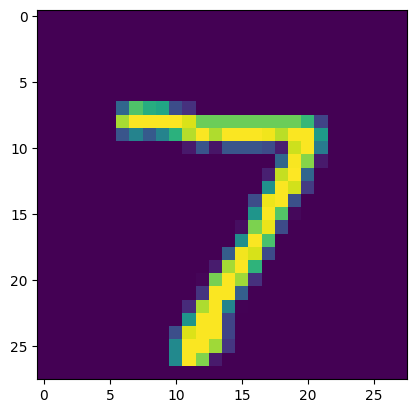

In [34]:
# Take one image as example for prediction
image, _ = test_data[0]
pil_image = transforms.ToPILImage()(image)
plt.imshow(pil_image)
plt.show()

### Get online predictions

You send a `predict` request with encoded input image data to the `endpoint` and get prediction.

In [35]:
buffered_image = io.BytesIO()
pil_image.save(buffered_image, format="JPEG")

data = {"data": base64.b64encode(buffered_image.getvalue()).decode("utf-8")}
prediction = endpoint.predict(instances=[data])

print(prediction.predictions)

[7.0]


### Make batch predictions (optional)

Learn more about [making batch predictions](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/prediction/pytorch_image_classification_with_prebuilt_serving_containers.ipynb) from your PyTorch model.

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [36]:
# Delete the deployment endpoint
endpoint.undeploy_all()
endpoint.delete()

# Delete the model from Model Registry
uploaded_model.delete()

# Delete Cloud Storage objects that were created
delete_bucket = False
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI

Undeploying Endpoint model: projects/818359284681/locations/us-central1/endpoints/4324911395670851584
Undeploy Endpoint model backing LRO: projects/818359284681/locations/us-central1/endpoints/4324911395670851584/operations/8120671619199795200
Endpoint model undeployed. Resource name: projects/818359284681/locations/us-central1/endpoints/4324911395670851584
Deleting Endpoint : projects/818359284681/locations/us-central1/endpoints/4324911395670851584
Delete Endpoint  backing LRO: projects/818359284681/locations/us-central1/operations/7992319029819736064
Endpoint deleted. . Resource name: projects/818359284681/locations/us-central1/endpoints/4324911395670851584
Deleting Model : projects/818359284681/locations/us-central1/models/436437946506149888
Delete Model  backing LRO: projects/818359284681/locations/us-central1/operations/6458843356700082176
Model deleted. . Resource name: projects/818359284681/locations/us-central1/models/436437946506149888
